Copyright ENEOS, Corp., Preferred Computational Chemistry, Inc. and Preferred Networks, Inc. as contributors to Matlantis contrib project

This notebook was machine translated from Japanese to English.

# Reaction Analysis on Heterogeneous Catalysts (NEB Method)


Table of Contents:
 - **[1. Creating Slab from Bulk](#chap1)**
 - **[2. Placing Molecule on Slab, Creating Initial State (Before Reaction) and Final State (After Reaction)](#chap2)**
 - **[3. NEB Calculation](#chap3)**
 - **[4. Checking NEB Calculation Results and Obtaining Transition State Structure](#chap4)**
 - **[5. Structure Optimization of Transition State (by Sella)](#chap5)**
 - **[6. Vibrational Analysis of Transition State](#chap6)**
 - **[7. Additional Analysis from Transition State (Pseudo-IRC Calculation)](#chap7)**

<a id="chap0"></a>
## Setup

In [1]:
# time.sleep(3600*10)
# # In a notebook, if there is no processing for 1.5 hours, the kernel will automatically shutdown.
# # If you want to keep the kernel, uncomment the line above and execute it.

In [2]:
!pip install pfp-api-client
!pip install pandas tqdm matplotlib seaborn optuna sella scikit-learn torch torch_dftd

# For the first use only, please install the libraries.

In [3]:
# General modules
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from IPython.display import display_png
from IPython.display import Image as ImageWidget
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from matplotlib.animation import PillowWriter
import seaborn as sns
import math
import optuna
import nglview as nv
import os,sys,csv,glob,shutil,re,time
from pathlib import Path
from PIL import Image, ImageDraw

# sklearn
from sklearn.metrics import mean_absolute_error


# ASE
import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.cluster.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import SingleCalculatorNEB
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.visualize import view
from ase.optimize import QuasiNewton
from ase.thermochemistry import IdealGasThermo
from ase.build.rotate import minimize_rotation_and_translation
from ase.visualize import view
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nptberendsen import NPTBerendsen, Inhomogeneous_NPTBerendsen
from ase.md import MDLogger
from ase.io import read, write, Trajectory
# from ase.calculators.dftd3 import DFTD3
from ase.build import sort

from sella import Sella, Constraints
# from torch_dftd.torch_dftd3_calculator import TorchDFTD3Calculator

# PFP
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.estimator import EstimatorCalcMode

estimator = Estimator(calc_mode="CRYSTAL")
calculator = ASECalculator(estimator)

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


In [4]:
# This cell is experimental, and the commands to suppress warnings that appear when calculating unexpected elements. Please execute only when necessary.
# from pfp_api_client.utils.messages import MessageEnum
# estimator.set_message_status(message=MessageEnum.ExperimentalElementWarning, message_enable=False)
# estimator.set_message_status(message=MessageEnum.UnexpectedElementWarning, message_enable=False)

In [9]:
def myopt(m,sn = 10,constraintatoms=[],cbonds=[]):
    fa = FixAtoms(indices=constraintatoms)
    fb = FixBondLengths(cbonds,tolerance=1e-5,)
    m.set_constraint([fa,fb])
    m.set_calculator(calculator)
    maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
    print("ini   pot:{:.4f},maxforce:{:.4f}".format(m.get_potential_energy(),maxf))
    de = -1 
    s = 1
    ita = 50
    while ( de  < -0.001 or de > 0.001 ) and s <= sn :
        opt = BFGS(m,maxstep=0.04*(0.9**s),logfile=None)
        old  =  m.get_potential_energy() 
        opt.run(fmax=0.0005,steps =ita)
        maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
        de =  m.get_potential_energy()  - old
        print("{} pot:{:.4f},maxforce:{:.4f},delta:{:.4f}".format(s*ita,m.get_potential_energy(),maxf,de))
        s += 1
    return m

def opt_cell_size(m,sn = 10, iter_count = False): # m:Atoms object
    m.set_constraint() # clear constraint
    m.set_calculator(calculator)
    maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max()) # Get the largest √(fx^2 + fy^2 + fz^2)
    ucf = ExpCellFilter(m)
    print("ini   pot:{:.4f},maxforce:{:.4f}".format(m.get_potential_energy(),maxf))
    de = -1 
    s = 1
    ita = 50
    while ( de  < -0.01 or de > 0.01 ) and s <= sn :
        opt = BFGS(ucf,maxstep=0.04*(0.9**s),logfile=None)
        old  =  m.get_potential_energy() 
        opt.run(fmax=0.005,steps =ita)
        maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
        de =  m.get_potential_energy()  - old
        print("{} pot:{:.4f},maxforce:{:.4f},delta:{:.4f}".format(s*ita,m.get_potential_energy(),maxf,de))
        s += 1
    if iter_count == True:
        return m, s*ita
    else:
        return m
    
#Create surface
def makesurface(atoms,miller_indices=(1,1,1),layers=4,rep=[4,4,1]):
    s1 = surface(atoms, miller_indices,layers)
    s1.center(vacuum=10.0, axis=2)
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0,0,min(s1.get_positions()[:,2])])
    s1.pbc = True
    return s1

In [10]:
import threading
import time
from math import pi
from typing import Dict, List, Optional

import nglview as nv
from ase import Atoms
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.visualize import view
from IPython.display import display
from ipywidgets import (
    Button,
    Checkbox,
    FloatSlider,
    GridspecLayout,
    HBox,
    IntSlider,
    Label,
    Text,
    Textarea,
)
from nglview.widget import NGLWidget


def save_image(filename: str, v: NGLWidget):
    """Save nglview image.

    Note that it should be run on another thread.
    See: https://github.com/nglviewer/nglview/blob/master/docs/FAQ.md#how-to-make-nglview-view-object-write-png-file

    Args:
        filename (str):
        v (NGLWidget):
    """
    image = v.render_image()
    while not image.value:
        time.sleep(0.1)
    with open(filename, "wb") as fh:
        fh.write(image.value)


class SurfaceEditor:
    """Structure viewer/editor"""

    struct: List[Dict]  # structure used for nglview drawing.

    def __init__(self, atoms: Atoms):
        self.atoms = atoms
        self.vh = view(atoms, viewer="ngl")
        self.v: NGLWidget = self.vh.children[0]  # VIEW
        self.v._remote_call("setSize", args=["450px", "450px"])
        self.recont()  # Add controller
        self.set_representation()
        self.set_atoms()
        self.pots = []
        self.traj = []
        self.cal_nnp()

    def display(self):
        display(self.vh)

    def recont(self):
        self.vh.setatoms = FloatSlider(
            min=0, max=50, step=0.1, value=8, description="atoms z>"
        )
        self.vh.setatoms.observe(self.set_atoms)
        self.vh.selected_atoms_label = Label("Selected atoms:")
        self.vh.selected_atoms_textarea = Textarea()
        selected_atoms_hbox = HBox(
            [self.vh.selected_atoms_label, self.vh.selected_atoms_textarea]
        )
        self.vh.move = FloatSlider(
            min=0.1, max=2, step=0.1, value=0.5, description="move"
        )

        grid1 = GridspecLayout(2, 3)
        self.vh.xplus = Button(description="X+")
        self.vh.xminus = Button(description="X-")
        self.vh.yplus = Button(description="Y+")
        self.vh.yminus = Button(description="Y-")
        self.vh.zplus = Button(description="Z+")
        self.vh.zminus = Button(description="Z-")
        self.vh.xplus.on_click(self.move)
        self.vh.xminus.on_click(self.move)
        self.vh.yplus.on_click(self.move)
        self.vh.yminus.on_click(self.move)
        self.vh.zplus.on_click(self.move)
        self.vh.zminus.on_click(self.move)
        grid1[0, 0] = self.vh.xplus
        grid1[0, 1] = self.vh.yplus
        grid1[0, 2] = self.vh.zplus
        grid1[1, 0] = self.vh.xminus
        grid1[1, 1] = self.vh.yminus
        grid1[1, 2] = self.vh.zminus

        self.vh.rotate = FloatSlider(
            min=1, max=90, step=1, value=30, description="rotate"
        )
        grid2 = GridspecLayout(2, 3)
        self.vh.xplus2 = Button(description="X+")
        self.vh.xminus2 = Button(description="X-")
        self.vh.yplus2 = Button(description="Y+")
        self.vh.yminus2 = Button(description="Y-")
        self.vh.zplus2 = Button(description="Z+")
        self.vh.zminus2 = Button(description="Z-")
        self.vh.xplus2.on_click(self.rotate)
        self.vh.xminus2.on_click(self.rotate)
        self.vh.yplus2.on_click(self.rotate)
        self.vh.yminus2.on_click(self.rotate)
        self.vh.zplus2.on_click(self.rotate)
        self.vh.zminus2.on_click(self.rotate)
        grid2[0, 0] = self.vh.xplus2
        grid2[0, 1] = self.vh.yplus2
        grid2[0, 2] = self.vh.zplus2
        grid2[1, 0] = self.vh.xminus2
        grid2[1, 1] = self.vh.yminus2
        grid2[1, 2] = self.vh.zminus2

        self.vh.nnptext = Textarea(disabled=True)

        self.vh.opt_step = IntSlider(
            min=0,
            max=100,
            step=1,
            value=10,
            description="Opt steps",
        )
        self.vh.constraint_checkbox = Checkbox(
            value=True,
            description="Opt only selected atoms",
        )
        self.vh.run_opt_button = Button(
            description="Run mini opt",
            tooltip="Execute BFGS optimization with small step update."
        )
        self.vh.run_opt_button.on_click(self.run_opt)
        opt_hbox = HBox([self.vh.constraint_checkbox, self.vh.run_opt_button])

        self.vh.filename_text = Text(value="screenshot.png", description="filename: ")
        self.vh.download_image_button = Button(
            description="download image",
            tooltip="Download current frame to your local PC",
        )
        self.vh.download_image_button.on_click(self.download_image)
        self.vh.save_image_button = Button(
            description="save image",
            tooltip="Save current frame to file.\n"
                    "Currently .png and .html are supported.\n"
                    "It takes a bit time, please be patient.",
        )
        self.vh.save_image_button.on_click(self.save_image)

        self.vh.update_display = Button(
            description="update_display",
            tooltip="Refresh display. It can be used when target atoms is updated in another cell..",
        )
        self.vh.update_display.on_click(self.update_display)

        r = list(self.vh.control_box.children)
        r += [
            self.vh.setatoms,
            selected_atoms_hbox,
            self.vh.move,
            grid1,
            self.vh.rotate,
            grid2,
            self.vh.nnptext,
            self.vh.opt_step,
            opt_hbox,
            self.vh.filename_text,
            HBox([self.vh.download_image_button, self.vh.save_image_button]),
            self.vh.update_display,
        ]
        self.vh.control_box.children = tuple(r)

    def set_representation(self, bcolor: str = "white", unitcell: bool = True):
        self.v.background = bcolor
        self.struct = self.get_struct(self.atoms)
        self.v.add_representation(repr_type="ball+stick")
        self.v.control.spin([0, 1, 0], pi * 1.1)
        self.v.control.spin([1, 0, 0], -pi * 0.45)
        thread = threading.Thread(target=self.changestr)
        thread.start()

    def changestr(self):
        time.sleep(2)
        self.v._remote_call("replaceStructure", target="Widget", args=self.struct)

    def get_struct(self, atoms: Atoms, ext="pdb") -> List[Dict]:
        struct = nv.ASEStructure(atoms, ext=ext).get_structure_string()
        for c in range(len(atoms)):
            struct = struct.replace("MOL     1", "M0    " + str(c).zfill(3), 1)
        struct = [dict(data=struct, ext=ext)]
        return struct

    def cal_nnp(self):
        pot = self.atoms.get_potential_energy()
        mforce = (((self.atoms.get_forces()) ** 2).sum(axis=1).max()) ** 0.5
        self.pot = pot
        self.mforce = mforce
        self.vh.nnptext.value = f"pot energy: {pot} eV\nmax force : {mforce} eV/A"
        self.pots += [pot]
        self.traj += [self.atoms.copy()]

    def update_display(self, clicked_button: Optional[Button] = None):
        print("update display!")
        struct = self.get_struct(self.atoms)
        self.struct = struct
        self.v._remote_call("replaceStructure", target="Widget", args=struct)
        self.cal_nnp()

    def set_atoms(self, slider: Optional[FloatSlider] = None):
        """Update text area based on the atoms position `z` greater than specified value."""
        smols = [
            i for i, atom in enumerate(self.atoms) if atom.z >= self.vh.setatoms.value
        ]
        self.vh.selected_atoms_textarea.value = ", ".join(map(str, smols))

    def get_selected_atom_indices(self) -> List[int]:
        selected_atom_indices = self.vh.selected_atoms_textarea.value.split(",")
        selected_atom_indices = [int(a) for a in selected_atom_indices]
        return selected_atom_indices

    def move(self, clicked_button: Button):
        a = self.vh.move.value

        for index in self.get_selected_atom_indices():
            if clicked_button.description == "X+":
                self.atoms[index].position += [a, 0, 0]
            elif clicked_button.description == "X-":
                self.atoms[index].position -= [a, 0, 0]
            elif clicked_button.description == "Y+":
                self.atoms[index].position += [0, a, 0]
            elif clicked_button.description == "Y-":
                self.atoms[index].position -= [0, a, 0]
            elif clicked_button.description == "Z+":
                self.atoms[index].position += [0, 0, a]
            elif clicked_button.description == "Z-":
                self.atoms[index].position -= [0, 0, a]
        self.update_display()

    def rotate(self, clicked_button: Button):
        atom_indices = self.get_selected_atom_indices()
        deg = self.vh.rotate.value
        temp = self.atoms[atom_indices]

        if clicked_button.description == "X+":
            temp.rotate(deg, "x", center="COP")
        elif clicked_button.description == "X-":
            temp.rotate(-deg, "x", center="COP")
        elif clicked_button.description == "Y+":
            temp.rotate(deg, "y", center="COP")
        elif clicked_button.description == "Y-":
            temp.rotate(-deg, "y", center="COP")
        elif clicked_button.description == "Z+":
            temp.rotate(deg, "z", center="COP")
        elif clicked_button.description == "Z-":
            temp.rotate(-deg, "z", center="COP")
        rotep = temp.positions
        for i, atom in enumerate(atom_indices):
            self.atoms[atom].position = rotep[i]
        self.update_display()

    def run_opt(self, clicked_button: Button):
        """OPT only specified steps and FIX atoms if NOT in text atoms list"""
        if self.vh.constraint_checkbox.value:
            # Fix non selected atoms. Only opt selected atoms.
            print("Opt with selected atoms: fix non selected atoms")
            atom_indices = self.get_selected_atom_indices()
            constraint_atom_indices = [
                i for i in range(len(self.atoms)) if i not in atom_indices
            ]
            self.atoms.set_constraint(FixAtoms(indices=constraint_atom_indices))
        opt = BFGS(self.atoms, maxstep=0.04, logfile=None)
        steps: Optional[int] = self.vh.opt_step.value
        if steps < 0:
            steps = None  # When steps=-1, opt until converged.
        opt.run(fmax=0.0001, steps=steps)
        print(f"Run opt for {steps} steps")
        self.update_display()

    def download_image(self, clicked_button: Optional[Button] = None):
        filename = self.vh.filename_text.value
        self.v.download_image(filename=filename)

    def save_image(self, clicked_button: Optional[Button] = None):
        filename = self.vh.filename_text.value
        if filename.endswith(".png"):
            thread = threading.Thread(
                target=save_image, args=(filename, self.v), daemon=True
            )
            # thread.daemon = True
            thread.start()
        elif filename.endswith(".html"):
            nv.write_html(filename, [self.v])  # type: ignore
        else:
            print(f"filename {filename}: extension not supported!")


<a id="chap1"></a>
## 1. Creating Slab from Bulk

### 1-1 Reading and Creating Bulk Structure

This time we will read in a cif file downloaded from the Materials Project and placed in the input folder.

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [11]:
bulk = read("input/Rh_mp-74_conventional_standard.cif")
print("number of atoms =", len(bulk))
print("initial lattice parameters =", bulk.cell.cellpar())

opt_cell_size(bulk)
print ("optimized lattice parameters =", bulk.cell.cellpar())

number of atoms = 4
initial lattice parameters = [ 3.843898  3.843898  3.843898 90.       90.       90.      ]
ini   pot:-22.9892,maxforce:0.0000
50 pot:-22.9928,maxforce:0.0000,delta:-0.0036
optimized lattice parameters = [ 3.83243616  3.83243608  3.83243603 89.99999969 89.99999916 89.99999892]


[sort](https://wiki.fysik.dtu.dk/ase/ase/build/tools.html#ase.build.sort) function is used to sort the order according to the atomic number.

In [12]:
bulk = bulk.repeat([2,2,2])               
bulk = sort(bulk)
bulk.positions += [0.01,0,0]   # Add a small padding to prevent cutting at strange positions when creating the surface.
v = view(bulk, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 1-2 Creating Slab Structure

Create a slab structure from the bulk structure with arbitrary Miller indices.<br/>
It can be specified by `miller_indices=(x,y,z)`. `makesurface` internally uses the [surface](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#create-specific-non-common-surfaces) function to create the surface structure.

In [13]:
slab = makesurface(bulk, miller_indices=(1,1,1), layers=2, rep=[1,1,1])
slab = sort(slab)
slab.positions += [1,1,0]         # Slightly adjust the position
slab.wrap()                       # then WRAP

v = view(slab, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 1-3 Checking z-coordinate of Created Slab

Check the highest coordinate of the slab (necessary when creating adsorption structure)<br/> 
Check the coordinates of each layer of the slab (necessary to determine up to which layer to fix)

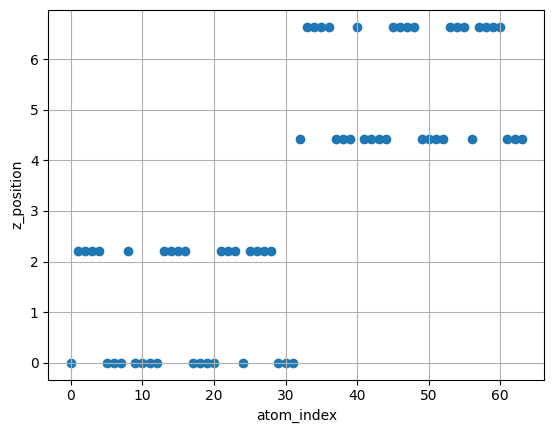

In [14]:
# Check the z_position of atoms.
z_pos = pd.DataFrame({
    "symbol": slab.get_chemical_symbols(),
    "z": slab.get_positions()[:, 2]
})

plt.scatter(z_pos.index, z_pos["z"])
plt.grid(True)
plt.xlabel("atom_index")
plt.ylabel("z_position")
plt.show()

In [15]:
print("highest position (z) =", z_pos["z"].max())

highest position (z) = 6.637974130376541


### 1-4 Fixing Bottom Layers of Slab Structure Cut from Surface and Performing Structure Optimization

By using [FixAtoms](https://wiki.fysik.dtu.dk/ase//ase/constraints.html#ase.constraints.FixAtoms), you can fix only the bottom layer atoms of the slab structure and run optimization.<br/>

Here, atoms below 1 Å are fixed, and only the bottom layer is fixed.
The surface atom positions should be relaxed.

In [17]:
%%time
c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <= 1])       # Fix atoms below 1A
slab.set_constraint(c)
slab.calc = calculator

os.makedirs("output", exist_ok=True)
BFGS_opt = BFGS(slab, trajectory="output/slab_opt.traj")#, logfile=None)
BFGS_opt.run(fmax=0.005)

      Step     Time          Energy         fmax
BFGS:    0 08:14:47     -341.470532        0.3359
BFGS:    1 08:14:47     -341.495208        0.3063
BFGS:    2 08:14:48     -341.627172        0.3010
BFGS:    3 08:14:48     -341.645696        0.2664
BFGS:    4 08:14:48     -341.776281        0.2265
BFGS:    5 08:14:48     -341.788580        0.2001
BFGS:    6 08:14:48     -341.821923        0.0127
BFGS:    7 08:14:48     -341.822219        0.0031
CPU times: user 91.2 ms, sys: 7.26 ms, total: 98.5 ms
Wall time: 654 ms


True

Looking at the actual optimization progress, it can be seen that only the top 3 layers are structurally optimized.

In [18]:
# v = view(slab, viewer='ngl')
v = view(Trajectory("output/slab_opt.traj"), viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [19]:
slabE = slab.get_potential_energy()
print(f"slab E = {slabE} eV")

slab E = -341.8222185059668 eV


In [20]:
# Save the created slab structure
os.makedirs("structures/", exist_ok=True)      # Create a folder named "structures/".
write("structures/Slab_Rh_111.xyz", slab)      # Change the file name as desired.

<a id="chap2"></a>
## 2. Placing Molecule on Slab, Creating Initial State (Before Reaction) and Final State (After Reaction)

### 2-1 Reading Adsorbing Molecule and Obtaining Potential Energy after Structure Optimization

This time we will use the [molecule module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) from ASE.<br/>
Reading from cif files, sdf files, etc. can also be done in the same way as reading bulk structures.

In [21]:
molec = molecule('NO')
# molec = read("structures/xxxxxxxxxx.sdf") # Example of reading from sdf file

In [22]:
molec.calc = calculator
BFGS_opt = BFGS(molec, trajectory="output/molec_opt.traj", logfile=None)
BFGS_opt.run(fmax=0.005)
molecE = molec.get_potential_energy()
print(f"molecE =　{molecE} eV")

molecE =　-7.17940702752068 eV


In [23]:
v = view(Trajectory("output/molec_opt.traj"), viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 2-2 Adsorption Energy Calculation

Let's create the adsorption state.
Here, we use the [add_adsorbate](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#ase.build.add_adsorbate) function to place `molec` on top of `slab`.

In [24]:
mol_on_slab = slab.copy()

# Enter the height and x,y position to place the molecule from the slab surface.
# It's okay to be approximate, as it can be adjusted later.
add_adsorbate(mol_on_slab, molec, height=3, position=(8, 4))
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)

#### SurfaceEditor

We use the `SurfaceEditor` class to optimize the adsorption position of the molecule.

<Usage>

1. Display the structure you want to edit with `SurfaceEditor(atoms).display()`.
2. Get the index of the molecule you want to move with atoms z>. The molecules above the highest coordinate of the slab structure confirmed in 1-3 are the target.<br/>When set, only the index of the selected molecule will be entered in the box below.
3. The molecule can be moved and its orientation changed with the XYZ+- of move and rotate.<br/>Adjusting the Ball size makes it easier to see the adsorption sites.
4. The "Run mini opt" button allows you to perform a specified number of steps of structure optimization using BFGS.

In this example, we will create the adsorption structure with reference to the following paper.

"First-Principles Microkinetic Analysis of NO + CO Reactions on Rh(111) Surface toward Understanding NOx Reduction Pathways"
 - https://pubs.acs.org/doi/10.1021/acs.jpcc.8b05906

In this example, pressing "X-" 3 times, "Y+" 1 time, and "Z-" 4 times allows you to create the initial structure for HCP site adsorption.<br/>
For the FCC and HCP sites of adsorption, please see the following figure.

<blockquote>
<figure>
<img src="https://www.researchgate.net/profile/Monica-Pozzo/publication/5521348/figure/fig1/AS:281313635520514@1444081805255/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen.png"/>
<figcaption>(Colour) Possible adsorption sites (top, bridge, hollow-hcp and hollow-fcc) for hydrogen (dark red) on the Mg(0001) surface (light blue).<br/>
from <a href="https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348">https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348</a>
</figcaption>
</figure>
</blockquote>

In [25]:
# # calculator needs to be set for SurfaceEditor.
mol_on_slab.calc = calculator

In [26]:
se = SurfaceEditor(mol_on_slab)
se.display()

In [27]:
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)
BFGS_opt = BFGS(mol_on_slab, logfile=None)
BFGS_opt.run(fmax=0.005)
mol_on_slabE = mol_on_slab.get_potential_energy()
print(f"mol_on_slabE = {mol_on_slabE} eV")

mol_on_slabE = -351.22060907911657 eV


In [28]:
os.makedirs("ad_structures/",  exist_ok=True)
write("ad_structures/mol_on_Rh(111).cif", mol_on_slab)

/home/jovyan/.py38/lib/python3.8/site-packages/ase/io/cif.py:787: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


### 2-3 Adsorption Energy

By looking at the energy difference between the slab and the molecule existing separately and when they are combined, the adsorption energy can be calculated.

In the above paper, it is 1.79 eV. The difference may be due to the fact that the RPBE functional is used in the paper, while the PBE functional is used in PFP.

In [29]:
# Calculate adsorption energy
adsorpE = slabE + molecE - mol_on_slabE
print(f"Adsorption Energy: {adsorpE} eV")

Adsorption Energy: 2.2189835456291007 eV


### 2-4 Listing Adsorption Structures

In [30]:
ad_st_path = "ad_structures/*"
ad_stru_list = [(filepath, read(filepath)) for filepath in glob.glob(ad_st_path)]

In [31]:
pd.DataFrame(ad_stru_list)

,0,1
0,ad_structures/mol_on_Rh(111).cif,"(Atom('Rh', [1.0070716190000002, 0.99592434902..."


In [32]:
No = 0
view(ad_stru_list[No][1] , viewer="ngl")

### 2-5 Creating IS Structure

Here, you create the IS structure and FS structure yourself and create a path for performing NEB.<br/>
Since we are using the ones created here this time, you can jump to [3. NEB Calculation](#chap3).

In [33]:
filepath, atoms = ad_stru_list[No]
print(filepath)
IS = atoms.copy()

ad_structures/mol_on_Rh(111).cif


In [34]:
IS.calc = calculator
SurfaceEditor(IS).display()

In [35]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.05)
IS.get_potential_energy()

-351.220462799779

### 2-6 Creating FS Structure

In [36]:
FS = IS.copy()

In [37]:
FS.calc = calculator
SurfaceEditor(FS).display()

In [38]:
FS.calc = calculator
c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
FS.get_potential_energy()

-351.22046670092027

Saving IS and FS structures

In [39]:
filepath = Path(filepath).stem
# filepath = Path(ad_stru_list[No][0]).stem
os.makedirs(filepath, exist_ok=True)
write(filepath+"/IS.cif", IS)
write(filepath+"/FS.cif", FS)

<a id="chap3"></a>
## 3. NEB Calculation

### 3-1 NEB Calculation

This time, let's perform an NEB calculation for the reaction NO(fcc) -> N(fcc) + O(fcc) that we have created.<br/> 
By changing the `filepath`, you can also try an NEB calculation for the reaction NO(fcc) -> N(hcp) + O(hcp).

In [40]:
!cp -r "input/NO_dissociation_NO(fcc)_N(fcc)_O(fcc)" .
!cp -r "input/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)" .

In [41]:
filepath = "NO_dissociation_NO(fcc)_N(fcc)_O(fcc)"
# filepath = "NO_dissociation_NO(fcc)_N(hcp)_O(hcp)"

The created IS and FS structures look like this.

In [42]:
IS = read(filepath+"/IS.cif")
FS = read(filepath+"/FS.cif")

v = view([IS, FS], viewer='ngl')
#v.view.add_representation("ball+stick")
display(v)

In [43]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.calc = calculator
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"IS {IS.get_potential_energy()} eV")

c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.calc = calculator
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"FS {FS.get_potential_energy()} eV")

IS -351.66097738797424 eV
FS -352.34999598784606 eV


In [44]:
beads = 21

In [45]:
b0 = IS.copy()
b1 = FS.copy()
configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
for config in configs:
    estimator = Estimator()                     # Required when using NEB with parallel=True, allowed_shared_calculator=False
    calculator = ASECalculator(estimator)       # Required when using NEB with parallel=True, allowed_shared_calculator=False
    config.calc = calculator

In [46]:
%%time
steps=2000

# k: spring constant, it's better to lower it to around 0.05 for stability.
# With NEB, setting parallel = True, allowed_shared_calculator=False is recommended as it is less affected by other jobs and progresses faster.
neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   
neb.interpolate()
relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log.txt")

# fmax below 0.05 is recommended. If it's too small, convergence takes time.
# For the first NEB calculation, perform with a loose convergence condition (e.g., 0.2), and if a reasonable reaction path is drawn, tighten the convergence condition for stable calculation.
# If an abnormal reaction path occurs with a loose convergence condition, review the IS and FS structures.
relax.run(fmax=0.1, steps=steps)

CPU times: user 19.9 s, sys: 3.61 s, total: 23.5 s
Wall time: 41.4 s


True

In [47]:
# additional calculation
steps=10000
relax.run(fmax=0.05, steps=steps)              

True

In [48]:
write(filepath+"/NEB_images.xyz", configs)

<a id="chap4"></a>
## 4. Checking NEB Calculation Results and Obtaining Transition State Structure

First, let's visualize in several ways. This time we will create a png --> gif file.

In [49]:
configs = read(filepath+"/NEB_images.xyz", index=":")

In [50]:
for config in configs:
    estimator = Estimator()                     # Required when using NEB with parallel=True, allowed_shared_calculator=False
    calculator = ASECalculator(estimator)       # Required when using NEB with parallel=True, allowed_shared_calculator=False
    config.calc = calculator

In [51]:
os.makedirs(filepath + "/pov_NEB/", exist_ok=True)
os.makedirs(filepath + "/png_NEB/", exist_ok=True)

for i, atoms in enumerate(configs):
    m = atoms.copy()
    write(filepath + f"/pov_NEB/NEB_{i:03}.pov", m, rotation="-60x, 30y, 15z")
    write(filepath + f"/png_NEB/NEB_{i:03}.png", m, rotation="-60x, 30y, 15z")

In [52]:
imgs = []
for i in sorted(glob.glob(filepath + "/png_NEB/*.png"))[:]:
    img = Image.open(i)
    img.load()
    #img = img.resize((250,480))
    bg = Image.new("RGB", img.size, (255, 255, 255))
    bg.paste(img, mask=img.split()[3])
    imgs.append(bg)

imgs[0].save(filepath + "/gif_NEB.gif", save_all=True, append_images=imgs[1:], optimize=False, duration=100, loop=0)

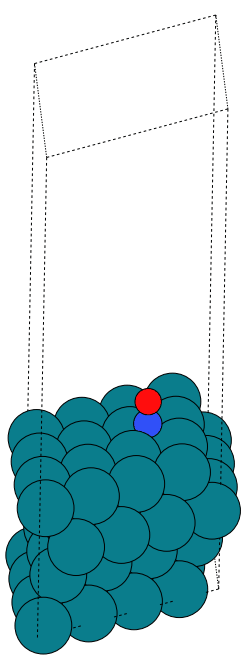

In [53]:
ImageWidget(filepath + "/gif_NEB.gif")

Check the Index that became the TS structure.<br/>
Looking at the Energy and Force, we can see that at `index=11`, the energy reaches a maximum and the Force reaches a saddle point near 0.

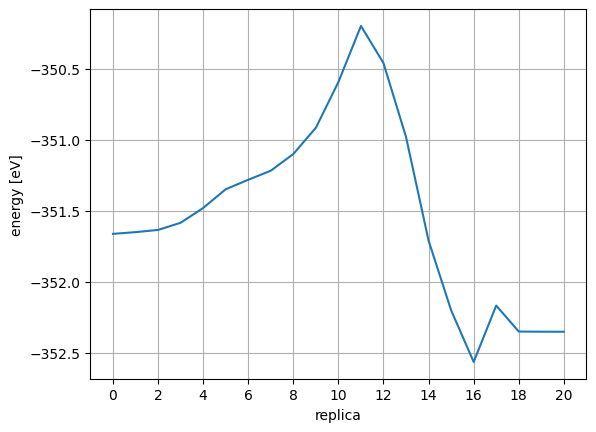

In [54]:
energies = [config.get_total_energy() for config in configs]
plt.plot(range(len(energies)),energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.xticks(np.arange(0, len(energies), 2))
plt.grid(True)
plt.show()

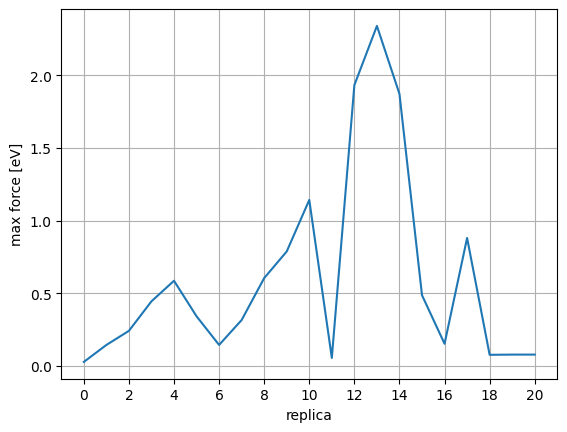

In [55]:
def calc_max_force(atoms):
    return ((atoms.get_forces() ** 2).sum(axis=1).max()) ** 0.5

mforces = [calc_max_force(config) for config in configs]
plt.plot(range(len(mforces)), mforces)
plt.xlabel("replica")
plt.ylabel("max force [eV]")
plt.xticks(np.arange(0, len(mforces), 2))
plt.grid(True)
plt.show()

The activation energy can be calculated by looking at the energy difference between the initial structure `index=0` and the transition state `index=11`.

In [56]:
ts_index = 11
actE = energies[ts_index] - energies[0]
deltaE = energies[ts_index] - energies[-1]
print(f"actE {actE} eV, deltaE {deltaE} eV")

actE 1.4641282520826167 eV, deltaE 2.1531501357864045 eV


In [57]:
v = view(configs, viewer='ngl')
#v.view.add_representation("ball+stick")
display(v)

### Redoing NEB

If an intermediate image structure is more suitable for the initial or final state than the NEB calculation result that has already been executed, extract that structure and re-execute.

In [58]:
# IS2 = configs[9].copy()
# FS2 = configs[-1].copy()

# c = FixAtoms(indices=[atom.index for atom in IS2 if atom.position[2] <= 1])
# IS2.calc = calculator
# IS2.set_constraint(c)
# BFGS_opt = BFGS(IS2, logfile=None)
# BFGS_opt.run(fmax=0.005)
# print(IS2.get_potential_energy())

# c = FixAtoms(indices=[atom.index for atom in FS2 if atom.position[2] <= 1])
# FS2.calc = calculator
# FS2.set_constraint(c)
# BFGS_opt = BFGS(FS2, logfile=None)
# BFGS_opt.run(fmax=0.005)
# print(FS2.get_potential_energy())

In [59]:
# write(filepath+"/IS2.cif", IS2)
# write(filepath+"/FS2.cif", FS2)

In [60]:
# v = view([IS2, FS2], viewer='ngl')
# #v.view.add_representation("ball+stick")
# display(v)

In [61]:
# beads = 21
# b0 = IS2.copy()
# b1 = FS2.copy()
# configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
# for config in configs:
#     estimator = Estimator()                     # Required when using NEB with parallel=True, allowed_shared_calculator=False
#     calculator = ASECalculator(estimator)       # Required when using NEB with parallel=True, allowed_shared_calculator=False
#     config.calc = calculator

In [62]:
# %%time
# steps=2000

# neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   #k: spring constant, it's better to lower it to around 0.05 for stability.
#                     # With NEB, setting parallel = True, allowed_shared_calculator=False is recommended as it is less affected by other jobs and progresses faster.
# neb.interpolate()
# relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log_2.txt")

# relax.run(fmax=0.05, steps=steps)              

In [63]:
# write(filepath+"/NEB_images2.xyz", configs)

In [64]:
# os.makedirs(filepath + "/pov_NEB2/", exist_ok=True)
# os.makedirs(filepath + "/png_NEB2/", exist_ok=True)

# for h,i in enumerate(configs):
#     m = i.copy()
#     write(filepath + '/pov_NEB2/NEB_' + str(h).zfill(3) + '.pov', m, rotation='-60x, 30y, 15z')
#     write(filepath + '/png_NEB2/NEB_' + str(h).zfill(3) + '.png', m, rotation='-60x, 30y, 15z')

In [65]:
# imgs = []
# for i in sorted(glob.glob(filepath + "/png_NEB2/*.png"))[:]:
#     img = Image.open(i)
#     img.load()
#     #img = img.resize((250,480))
#     bg = Image.new("RGB", img.size, (255, 255, 255))
#     bg.paste(img, mask=img.split()[3])
#     imgs.append(bg)

# imgs[0].save(filepath + "/gif_NEB_2.gif", save_all=True, append_images=imgs[1:], optimize=False, duration=100, loop=0)

In [66]:
# energies = [config.get_total_energy() for config in configs]
# plt.plot(range(len(energies)),energies)
# plt.xlabel("replica")
# plt.ylabel("energy [eV]")
# plt.xticks(np.arange(0, beads, 2))
# plt.grid(True)
# plt.show()

In [67]:
# mforces = [config.get_forces().max() for config in configs]
# plt.plot(range(len(mforces)),mforces)
# plt.xlabel("replica")
# plt.ylabel("max force [eV]")
# plt.xticks(np.arange(0, beads, 2))
# plt.grid(True)
# plt.show()

In [68]:
# energies[13] - energies[0]

In [69]:
# v = view(configs, viewer='ngl')
# #v.view.add_representation("ball+stick")
# display(v)

<a id="chap5"></a>
## 5. Structure Optimization of Transition State (by Sella)

The TS structure obtained in the previous chapter has not been strictly converged to a saddle point.
Here, we use a library called [sella](https://github.com/zadorlab/sella) to converge the TS structure.

In [70]:
TSNo = 11
TS = configs[TSNo].copy()
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])
TS.set_constraint(c)

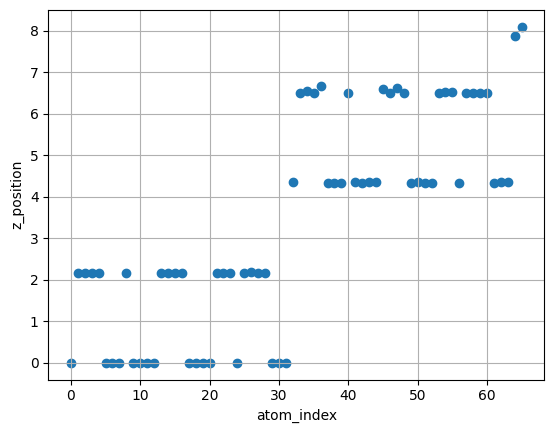

In [71]:
# Check the z_position of atoms.
z_pos = pd.DataFrame({
    "symbol": TS.get_chemical_symbols(),
    "z": TS.get_positions()[:, 2]
})

plt.scatter(z_pos.index, z_pos["z"])
plt.grid(True)
plt.xlabel("atom_index")
plt.ylabel("z_position")
#plt.ylim(14,22)
plt.show()

In [72]:
TS.calc = calculator  
TSopt = Sella(TS)         # TS optimization with Sella
%time TSopt.run(fmax=0.05)
potentialenergy = TS.get_potential_energy()
print (TS.get_potential_energy(), TS.get_forces().max())

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 08:17:24     -350.196849       0.0377       0.0000       0.1000       1.0000
CPU times: user 212 ms, sys: 6.41 ms, total: 219 ms
Wall time: 308 ms
-350.19684931328925 0.036543313188416526


In [73]:
write(filepath + "/TS_opt.cif", TS)

In [74]:
# Compare structures before and after TS optimization
v = view([configs[TSNo], TS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

<a id="chap6"></a>
## 6. Vibrational Analysis of Transition State

In [75]:
# Elements to be analyzed by vibrational calculation are those with z_pos >= zz.
vibatoms = z_pos[z_pos["z"] >= 7.0].index
vibatoms

Index([64, 65], dtype='int64')

In [76]:
# Vibrational calculation

vibpath = filepath + "/TS_vib/vib"
os.makedirs(vibpath, exist_ok=True)
vib = Vibrations(TS, name=vibpath, indices=vibatoms)         # Specify the elements for vibrational calculation here with vibatoms.
vib.run()
vib_energies = vib.get_energies()

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=TS,
                        geometry='linear',     #'monatomic', 'linear', or 'nonlinear'
                        symmetrynumber=2, spin=0, natoms=len(vibatoms))
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

Enthalpy components at T = 298.15 K:
E_pot               -350.197 eV
E_ZPE                  0.032 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.026 eV
Cv_vib (0->T)          0.006 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                   -350.069 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022653 eV/K        0.675 eV
S_rot              0.0012600 eV/K        0.376 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0000263 eV/K        0.008 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0035504 eV/K        1.059 eV

Free energy components at T = 298.15 K and P = 101325.0 Pa:
    H       -350.069 eV
 -T*S         -1.059 eV
-----------------------
    G       -351.127 eV


In [77]:
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   67.6i    545.4i
  1   22.8     184.1
  2   26.3     212.4
  3   51.3     413.9
  4   59.2     477.7
  5   64.7     522.0
---------------------
Zero-point energy: 0.112 eV


In [78]:
vib.summary(log=filepath+"/vib_summary.txt")

In [79]:
# Output traj file for displaying each vibrational mode.
vib.write_mode(n=0, kT=300*kB, nimages=30)
vib.clean()

13

In [80]:
n = 0      # Check the summary table and enter the number of the vibrational mode you want to display.
vib_traj = Trajectory(vibpath + f".{n}.traj")
v = view(vib_traj, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [81]:
write(filepath + "/vib_traj.xyz", vib_traj)

In [82]:
vib_traj = read(filepath + "/vib_traj.xyz", index=":")

In [83]:
os.makedirs(filepath + "/pov_VIB/", exist_ok=True)
os.makedirs(filepath + "/png_VIB/", exist_ok=True)

for h,i in enumerate(vib_traj):
    m = i.copy()
    write(filepath + f"/pov_VIB/VIB_{h:03}.pov", m, rotation='-60x, 30y, 15z')
    write(filepath + f"/png_VIB/VIB_{h:03}.png", m, rotation='-60x, 30y, 15z')

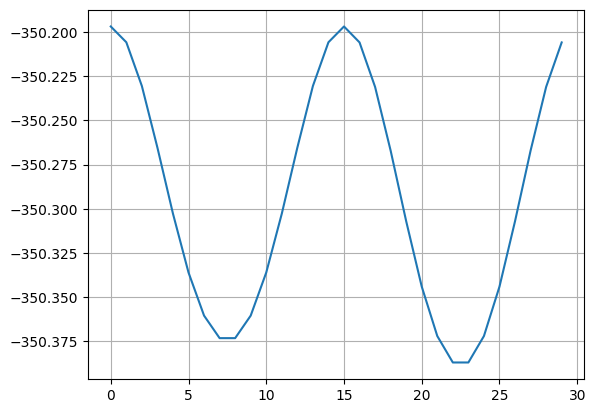

In [84]:
# Check if it becomes an imaginary frequency. The middle (and 0) is TS.

vib_energies = []
for i in vib_traj:
    i.calc = calculator
    vib_energies.append(i.get_potential_energy())
plt.plot(range(len(vib_energies)), vib_energies)
plt.grid(True)
plt.show()

<a id="chap7"></a>
## 7. Additional Analysis from Transition State (Pseudo-IRC Calculation) Work in Progress

In [ ]:
from ase.optimize.basin import BasinHopping
from ase.optimize.minimahopping import MinimaHopping

In [ ]:
TS = read("mol_on_Rh(111)/TS_opt.cif")
TS.calc = calculator

In [ ]:
# Just bring the structures on both sides of the imaginary frequency mode and optimize with BFGS.
c = FixAtoms(indices=[atom.index for atom in vib_traj[15] if atom.position[2] <= 1])

IRC_IS = vib_traj[14].copy()
IRC_IS.calc = calculator
IRC_IS.set_constraint(c)
# opt = BFGS(IRC_IS, logfile=None, maxstep=1)
# opt.run(fmax=0.5)
opt = BasinHopping(IRC_IS, temperature=300 * kB, dr=0.5, optimizer=LBFGS, fmax=0.005,)
print ("IS_done")

IRC_FS = vib_traj[16].copy()
IRC_FS.calc = calculator
IRC_FS.set_constraint(c)
# opt = BFGS(IRC_FS, logfile=None, maxstep=1)
# opt.run(fmax=0.5)
opt = BasinHopping(IRC_FS, temperature=300 * kB, dr=0.5, optimizer=LBFGS, fmax=0.005,)
print ("FS_done")

In [ ]:
# Just bring the structures on both sides of the imaginary frequency mode and optimize with BFGS.
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])

IRC_IS = vib_traj[14].copy()
IRC_IS.calc = calculator
IRC_IS.set_constraint(c)
opt = BFGS(IRC_IS, logfile=None, maxstep=0.5)
opt.run(fmax=0.005, steps=500)
print ("IS_BFGS_done")
opt = MinimaHopping(IRC_IS, T0=0, fmax=0.005,)
opt(totalsteps=10)
print ("IS_MH_done")

IRC_FS = vib_traj[16].copy()
IRC_FS.calc = calculator
IRC_FS.set_constraint(c)
opt = BFGS(IRC_FS, logfile=None, maxstep=0.5)
opt.run(fmax=0.005, steps=500)
print ("FS_BFGS_done")
#opt = MinimaHopping(IRC_FS, T0=0, fmax=0.005,)
#opt(totalsteps=10)
print ("FS_MH_done")

In [ ]:
v = view([IRC_IS, TS, IRC_FS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [ ]:
# Compare the energies of IS, TS, FS calculated by NEB with the results of TSopt+IRC.
plt.plot([0,1,2], [configs[0].get_potential_energy(), configs[TSNo].get_potential_energy(), configs[-1].get_potential_energy()], label="NEB")
plt.plot([0,1,2], [IRC_IS.get_potential_energy(), TS.get_potential_energy(), IRC_FS.get_potential_energy()], label="TSopt+IRC")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(TS.get_potential_energy() - IRC_IS.get_potential_energy())
print(TS.get_potential_energy() - IRC_FS.get_potential_energy())

In [ ]:
write(filepath + "/IS_IRC.xyz",IRC_IS)
write(filepath + "/FS_IRC.xyz",IRC_FS)